In [9]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [10]:
import os
import numpy as np
import torch

import cv2
import matplotlib.pyplot as plt

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.utils.model_utils import load_model

In [11]:
data_dir = "../data"
#data_dir = "/home/blah-buttery/nanoparticles/images/normal" # gpu workstation
#data_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook image
image_size = (1024, 1024)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir, image_size, batch_size)

In [12]:
model_path = "../saved_models/ae_1000_epochs.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = create_autoencoder().to(device)
autoencoder = load_model(autoencoder, model_path, device=device)
autoencoder.eval() 
print("Locked and loaded")

Loading model from: ../saved_models/ae_1000_epochs.pth
Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Locked and loaded


In [13]:
def process_and_store_images(sample_img, reconstructed_img):
    """
    Processes and stores clamped NumPy representations of original and reconstructed images.

    Args:
        sample_img (torch.Tensor): Batch of original images (B, C, H, W).
        reconstructed_img (torch.Tensor): Batch of reconstructed images (B, C, H, W).

    Returns:
        tuple: Two lists containing processed original and reconstructed images as NumPy arrays.
    """
    original_images = []
    reconstructed_images = []

    # Iterate over the batch
    for img_idx in range(sample_img.size(0)):
        original_np = torch.clamp(sample_img[img_idx], min=0, max=1).cpu().numpy()
        reconstructed_np = torch.clamp(reconstructed_img[img_idx], min=0, max=1).cpu().numpy()

        # Store the processed representations
        original_images.append(original_np)
        reconstructed_images.append(reconstructed_np)

    return original_images, reconstructed_images

In [14]:
def display_image(image_array, color_mode="grayscale", title="Image"):
    """
    Displays an image from a NumPy array.

    Args:
        image_array (np.ndarray): The image as a NumPy array. For grayscale, it should have shape (H, W). For RGB, it should have shape (H, W, C).
        color_mode (str): "grayscale" for single-channel images, "rgb" for multi-channel images.
        title (str): Title of the displayed image.

    Raises:
        ValueError: If the provided color_mode is neither "grayscale" nor "rgb".
    """
    plt.figure(figsize=(12, 12))
    if color_mode == "grayscale":
        plt.imshow(image_array.squeeze(), cmap="gray")
    elif color_mode == "rgb":
        image_array = image_array.transpose(1, 2, 0)  # Convert to HWC for RGB
        plt.imshow(image_array)
    else:
        raise ValueError("Invalid color_mode. Use 'grayscale' or 'rgb'.")

    plt.axis("off")
    plt.title(title)
    plt.show()

In [15]:
all_original_images = []
all_reconstructed_images = [] 

# Process one batch
sample_batch = next(iter(test_loader))
sample_batch = sample_batch.to(device)

with torch.no_grad():
    reconstructed_batch = autoencoder(sample_batch)

# Process and store the batch
processed_original_images, processed_reconstructed_images = process_and_store_images(sample_batch, reconstructed_batch)

# Aggregate results
all_original_images.extend(processed_original_images)
all_reconstructed_images.extend(processed_reconstructed_images)

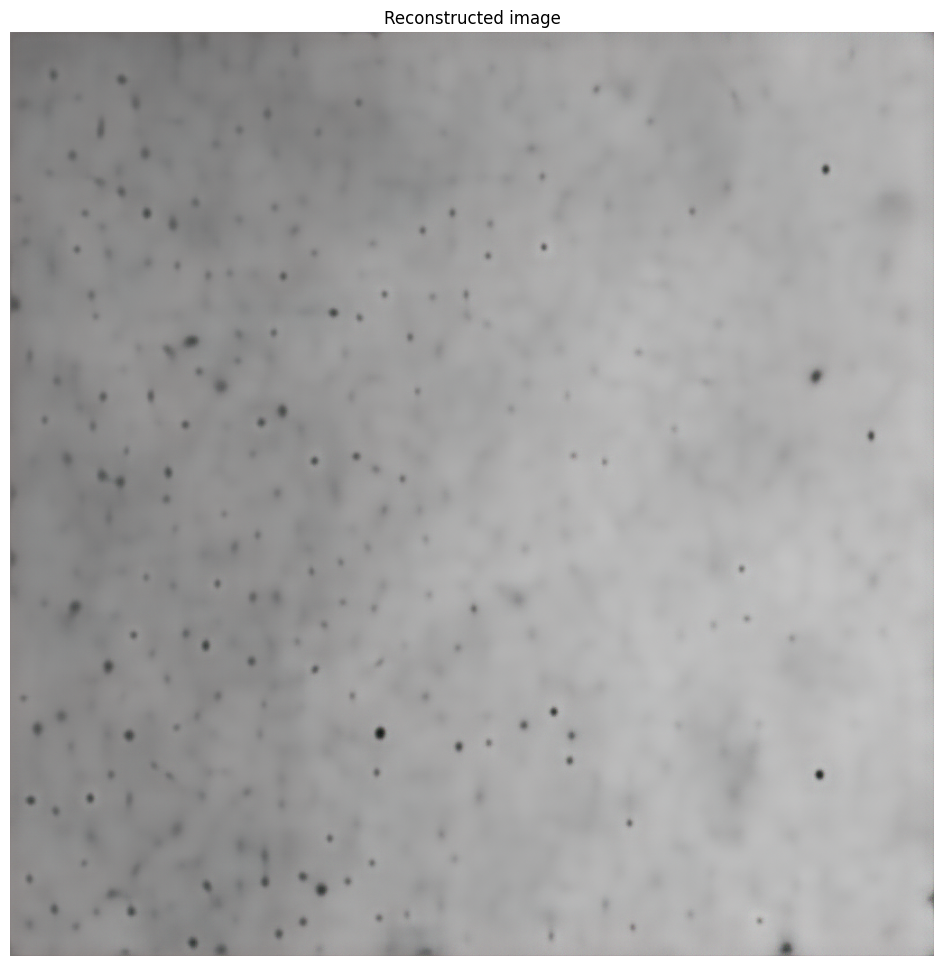

In [18]:
display_image(all_reconstructed_images[0], color_mode="rgb", title="Reconstructed image")

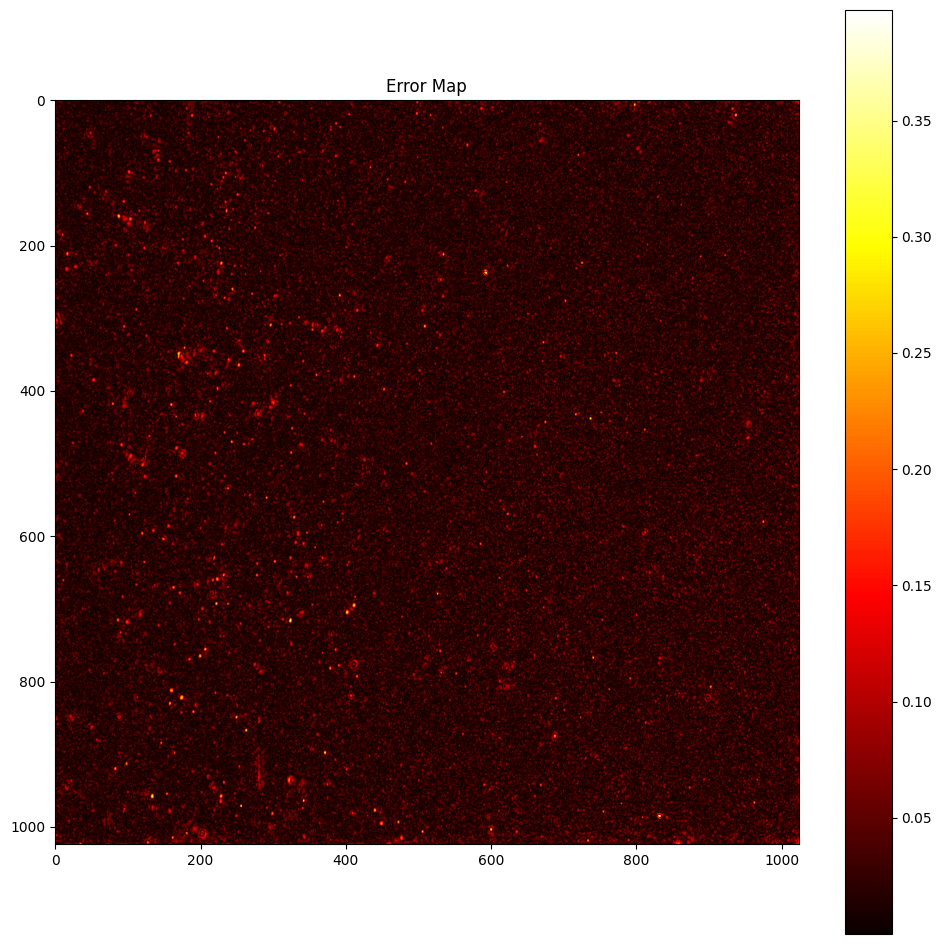

In [19]:
error_map = np.abs(all_original_images[0] - all_reconstructed_images[0]).mean(axis=0)

plt.figure(figsize=(12,12))
plt.imshow(error_map, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

The errors are the small particles and background noise, so the issue is that the model is too good to use for error contouring.

In [20]:
def detect_and_overlay_contours(reconstructed_img, original_img, min_area=10, max_area=1000, with_labels=False, save_path=None):
    """
    Detects exact contours on the reconstructed image and overlays them on the original image.

    Args:
        reconstructed_img (np.ndarray): Reconstructed image as a NumPy array (H, W).
        original_img (np.ndarray): Original image as a NumPy array (H, W).
        min_area (int): Minimum particle area to be considered valid.
        max_area (int): Maximum particle area to be considered valid.
        with_labels (bool): Whether to label the contours on the image.
        save_path (str): Path to save the plot. If None, the plot will not be saved.

    Returns:
        None: Displays the original image with contours overlaid.
    """
    
    reconstructed_scaled = (reconstructed_img * 255).astype(np.uint8)

    if len(reconstructed_scaled.shape) != 2:
        raise ValueError("Reconstructed image must be a single-channel grayscale image.")

    if len(original_img.shape) != 2:
        raise ValueError("Original image must be a single-channel grayscale image.")

    # Apply adaptive thresholding
    thresholded_img = cv2.adaptiveThreshold(
        reconstructed_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Find contours
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area
    valid_contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    original_colored = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Overlay contours and optionally add labels
    for i, contour in enumerate(valid_contours):
        cv2.drawContours(original_colored, [contour], -1, (0, 255, 0), thickness=1)  # Green contours

        if with_labels:
            # Calculate the centroid of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:  # Avoid division by zero
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(
                    original_colored, str(i + 1), (cX, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), thickness=1
                )

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(original_colored, cv2.COLOR_BGR2RGB))
    title = "Contours on Original with Labels" if with_labels else "Contours on Original"
    plt.title(title)
    plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")  # Save the plot to the specified path

    plt.show()

    print(f"Particles detected: {len(valid_contours)}")

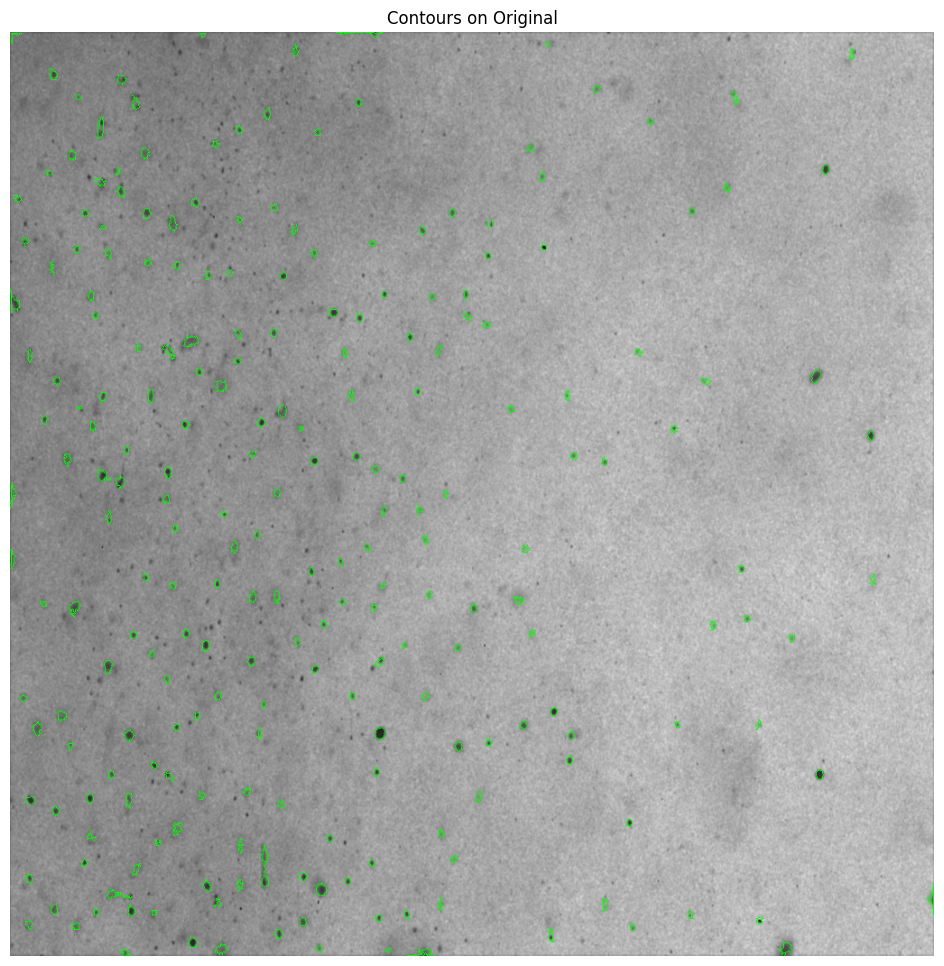

Particles detected: 238


In [21]:
#test first image in test_loader

reconstructed_grayscale = np.mean(all_reconstructed_images[0], axis=0)  # Convert to grayscale
original_grayscale = np.mean(all_original_images[0], axis=0)  # Convert to grayscale

detect_and_overlay_contours(reconstructed_grayscale, original_grayscale, min_area=10, max_area=1000, with_labels=False)

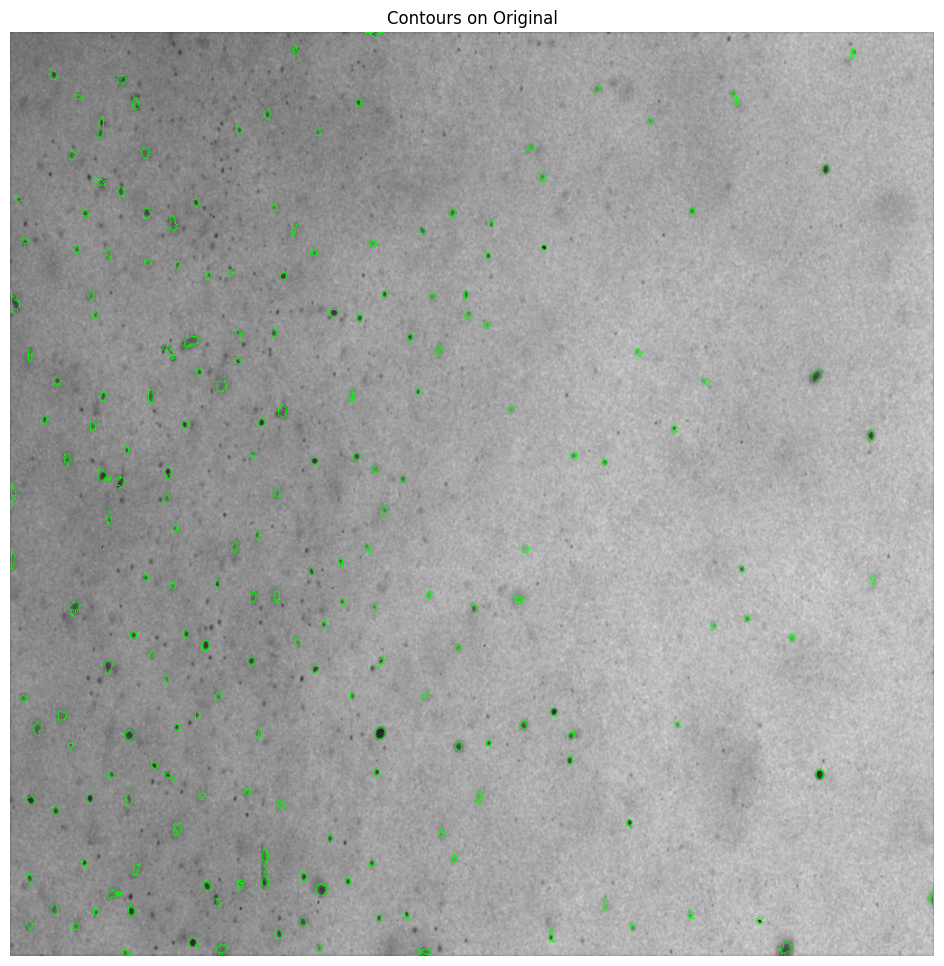

Particles detected: 205


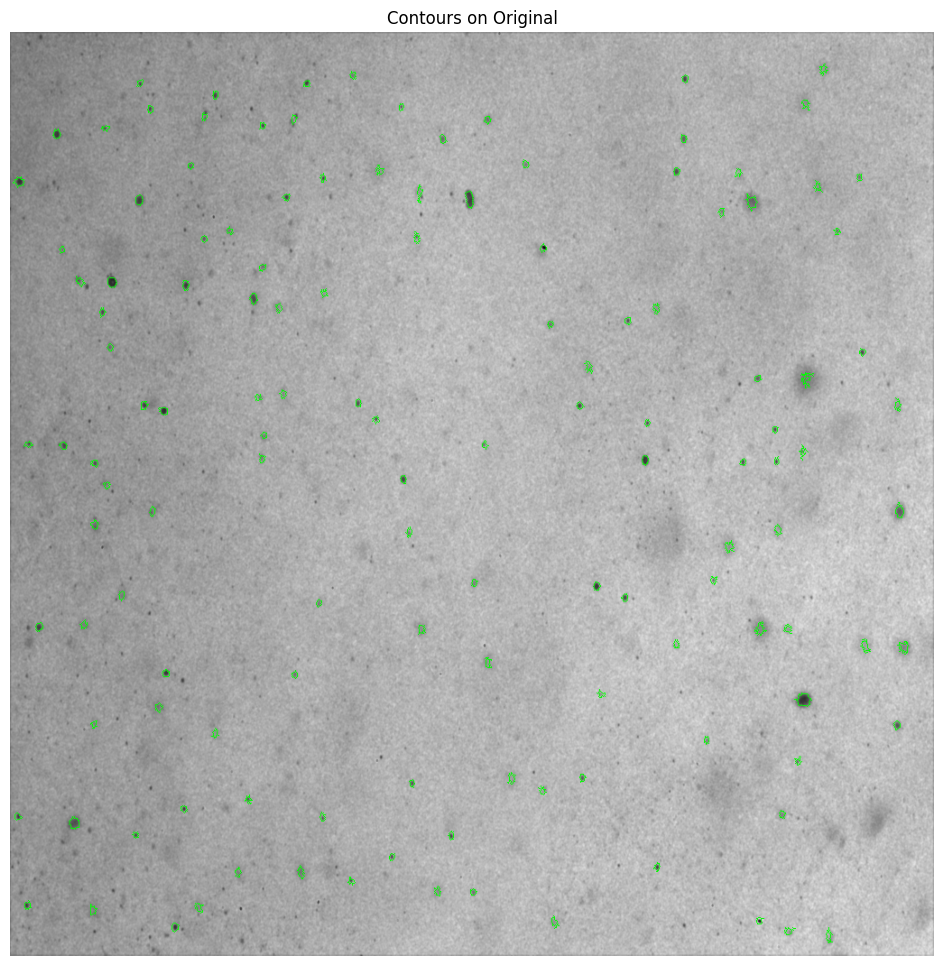

Particles detected: 134


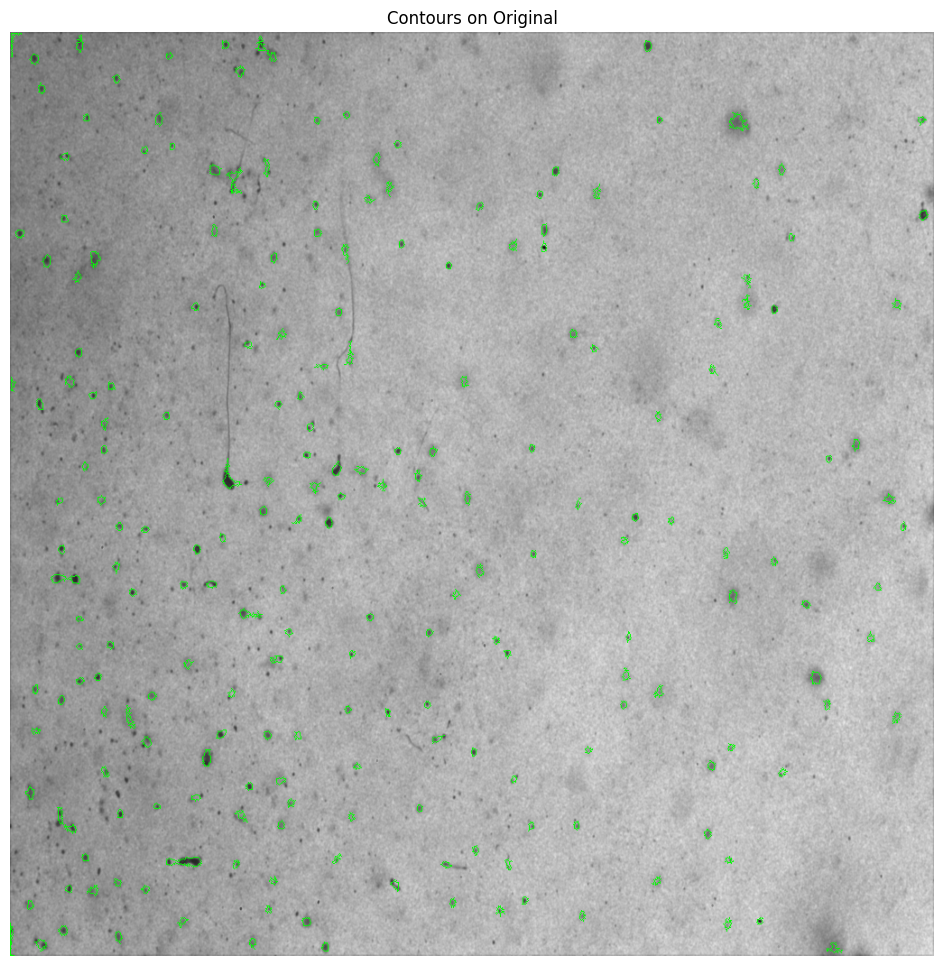

Particles detected: 220


In [22]:
#test the entire test_loader

for idx in range(len(all_original_images)):
    # Convert images to grayscale
    reconstructed_grayscale = np.mean(all_reconstructed_images[idx], axis=0)  # Convert to grayscale
    original_grayscale = np.mean(all_original_images[idx], axis=0)  # Convert to grayscale
    
    detect_and_overlay_contours(reconstructed_grayscale, original_grayscale, min_area=25, max_area=250, with_labels=False)
